# TruSHAP

Add your model to a TruEra deployment with only 2! code changes to your notebooks that already use SHAP.

### 0.1: Import Packages

In [1]:
from truera.client.experimental.trushap import trushap as shap
from sklearn.tree import DecisionTreeRegressor
import xgboost
from sklearn.model_selection import train_test_split

/Users/jreini/opt/anaconda3/envs/trushap_dogfood/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.2: Train the Model

In [2]:
X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size = 0.3,
                                    random_state = 123)
                                    
model = xgboost.XGBRegressor().fit(X_train, y_train)

### 1.0: Get Shapley Values

In [3]:
#connection details
CONNECTION_STRING = ""
TOKEN = ""

In [4]:
#just add connection string and token (optional)
explainer = shap.Explainer(model, connection_string = CONNECTION_STRING, token = TOKEN)

shap_values = explainer(X)

### 1.1 Use existing SHAP Functionality

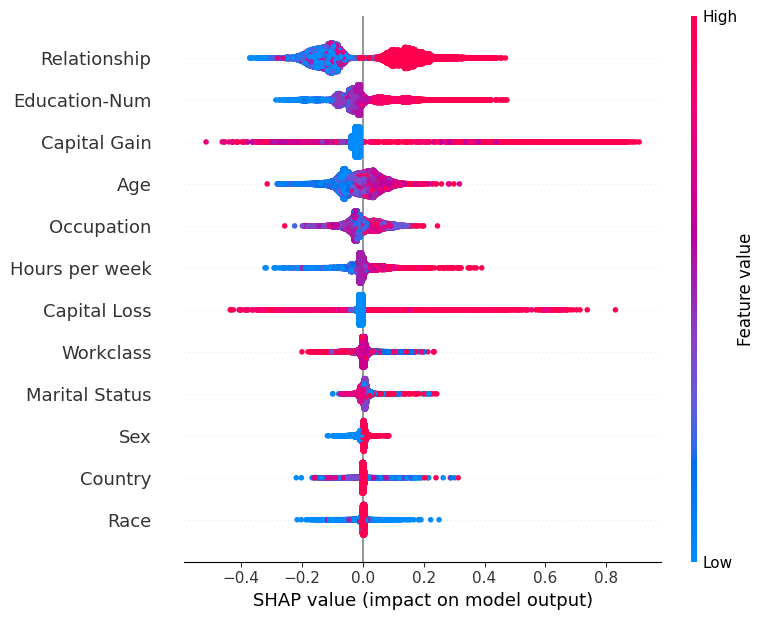

In [5]:
shap.summary_plot(shap_values, X)

### 1.2: Explore your new project in the TruEra Web App

Visit your TruEra application and explore to better understand the performance of your model.

### 1.3: Be intentional about naming

In [12]:
#add naming
explainer = shap.Explainer(model, connection_string = CONNECTION_STRING, token = TOKEN,
                            project = "Adult Census Example",
                            data_collection_name = "Adult Census Data Collection",
                            model_name = "XGBRegressor V1"
                            )

shap_values = explainer(X, data_split_name = "all", split_type = "all")

### 1.4: Add y (label data)

In [13]:
shap_values = explainer(X, data_split_name = "all_w_labels", y = y, split_type = "all")

### 1.6: Compare models against each other and across multiple splits

In [ ]:
#Add multiple models
xgb_model = xgboost.XGBRegressor(max_depth = 6, min_child_weight = 2).fit(X_train, y_train)

explainer_xgb = shap.Explainer(xgb_model,
                            connection_string = CONNECTION_STRING,
                            token = TOKEN,
                            project = "Adult Census Model Comparison",
                            data_collection_name = "Adult Census Data Collection",
                            model_name = "XGBRegressor",
                            train_parameters = {"max_depth":6,
                                                "min_child_weight":2}
                            )

shap_values_xgb_train = explainer_xgb(X_train, data_split_name = "train", y = y_train, split_type = "train")
shap_values_xgb_test = explainer_xgb(X_test, data_split_name = "test", y = y_test, split_type = "test")

tree_model = DecisionTreeRegressor(max_depth=6).fit(X_train, y_train)

explainer_tree = shap.Explainer(tree_model,
                            connection_string = CONNECTION_STRING,
                            token = TOKEN,
                            project = "Adult Census Model Comparison",
                            data_collection_name = "Adult Census Data Collection",
                            model_name = "Decision Tree Regression",
                            train_parameters = {"max_depth": 6}
                            )

shap_values_tree_train = explainer_tree(X_train, data_split_name = "train", y = y_train, split_type = "train")
shap_values_tree_test = explainer_tree(X_test, data_split_name = "test", y = y_test, split_type = "test")

## 2.0: Unlock More Capabilities

### 2.1.0: Using the TruEra Explainer - Plotting

In [ ]:
tru = explainer.get_truera_workspace()

tru_explainer = tru.get_explainer('all_w_labels')

tru_explainer.get_global_feature_importances()

tru_explainer.plot_isp('Age')

### 2.1.1 Using the TruEra Explainer - Find High Error Segments

In [ ]:
tru_explainer.suggest_high_error_segments()

,representation,MAE,size,size (%)
0,Relationship <= 5.0 AND Relationship >= 4.0,0.285735,14761,45.333374
1,"""Marital Status"" <= 2.0 AND ""Marital Status"" >...",0.283698,14976,45.993673
2,"""Hours per week"" <= 70.0 AND ""Hours per week"" ...",0.241028,8677,26.648444


### 2.2: Get Serious with the Test Harness

Establish performance, fairness, feature importance and stability tests using the TruEra Test Harness.

1. Performance tests warn and/or fail if any of a number of metrics (accuracy, precision, AUC, etc) reaches a specified threshold.

2. Fairness tests establish criteria to compare a protected segment against the rest of the population.

3. Feature Importance tests ensure there are not too many unimportant features in the model.

4. Stability ensures that the behavior of the model is similar across two distributions.

In [ ]:
#set environment to the remote project, set context in remote
tru.set_environment("remote")
tru.set_project("Adult Census Model Comparison")
tru.set_data_collection("Adult Census Data Collection")
tru.set_data_split("train")

#set up protected segment for fairness test
#tru.add_segment_group(name = "Gender", segment_definitions = dict({"Male": 'Sex == 1', 'Female': 'Sex == 0'}) )
tru.set_as_protected_segment(segment_group_name = "Gender", segment_name = "Female")

#performance test
for split_name in ["train", "test"]:
    tru.tester.add_performance_test( test_name = "Performance Test 1",
        data_split_names = [split_name],
        fail_if_greater_than = 0.3,
        metric = "RMSE",
        overwrite = True)

    #fairness test
    tru.tester.add_fairness_test( test_name = "Fairness Test 1",
    data_split_names = [split_name],
    all_protected_segments=True,
    metric = "MEAN_SCORE_DIFFERENCE",
    fail_if_outside = [-0.1,0.1], warn_if_outside = [-0.05, 0.05],
    overwrite = True)

    #feature importance test
    tru.tester.add_feature_importance_test(test_name = "FI Test 1",
                                            data_split_names = [split_name],
                                            min_importance_value= 0.02,
                                            warn_if_greater_than = 0,
                                            fail_if_greater_than = 5,
                                            overwrite = True)

#stability test
tru.tester.add_stability_test(test_name = "Stability Test 1",
                                base_data_split_name="train",
                                comparison_data_split_names=["test"],
                                metric="DIFFERENCE_OF_MEAN",
                                warn_if_greater_than = 0.1)

### 2.3: Check the Model Leaderboard

In [ ]:
tru.tester.get_model_leaderboard()

Model Name,Train Split Name,Train Parameters,Performance Tests (Failed/Warning/Total),Fairness Tests (Failed/Warning/Total),Stability Tests (Failed/Warning/Total),Feature Importance Tests (Failed/Warning/Total)
XGBRegressor,Unspecified,max_depth: 6.0min_child_weight: 2.0,1 ❌ / 0 ⚠️ / 1,1 ❌ / 0 ⚠️ / 1,0 ❌ / 0 ⚠️ / 1,0 ❌ / 1 ⚠️ / 1
Decision Tree Regression,Unspecified,max_depth: 6.0,1 ❌ / 0 ⚠️ / 1,1 ❌ / 0 ⚠️ / 1,0 ❌ / 0 ⚠️ / 1,1 ❌ / 0 ⚠️ / 1


### 2.4 Explore the Test Results Further

In [ ]:
tru.set_model("XGBRegressor")
tru.tester.get_model_test_results()

### 2.5 Explore failed tests using your TruEra Web App (Explore in the UI)